In [95]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import cv2
import mediapipe as mp
import shutil
import sys
import warnings
import os

In [3]:
warnings.filterwarnings("ignore", category=UserWarning, module='google.protobuf')

In [4]:
data = pd.read_csv('data/hand_augmented_landmarks.csv')
data.head()

,joint0_x,joint0_y,joint0_z,joint1_x,joint1_y,joint1_z,joint2_x,joint2_y,joint2_z,joint3_x,...,joint18_x,joint18_y,joint18_z,joint19_x,joint19_y,joint19_z,joint20_x,joint20_y,joint20_z,class
0,150,223,-0.000002,105,194,-0.044882,80,135,-0.065501,76,...,203,113,-0.138853,199,141,-0.113921,193,166,-0.073064,A
1,150,244,-0.000001,191,208,-0.041771,223,156,-0.054642,235,...,106,115,-0.085019,111,146,-0.063702,114,174,-0.028340,A
2,189,262,-0.000001,141,224,-0.037081,105,174,-0.060489,88,...,214,127,-0.102480,214,156,-0.093026,213,184,-0.066689,A
3,150,260,-0.000001,203,227,-0.084459,234,154,-0.108058,231,...,96,139,-0.111384,112,184,-0.096218,117,217,-0.057913,A
4,152,268,-0.000002,96,230,-0.049804,65,157,-0.067362,65,...,203,139,-0.155964,190,183,-0.131286,186,214,-0.085012,A


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245805 entries, 0 to 245804
Data columns (total 64 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   joint0_x   245805 non-null  int64  
 1   joint0_y   245805 non-null  int64  
 2   joint0_z   245805 non-null  float64
 3   joint1_x   245805 non-null  int64  
 4   joint1_y   245805 non-null  int64  
 5   joint1_z   245805 non-null  float64
 6   joint2_x   245805 non-null  int64  
 7   joint2_y   245805 non-null  int64  
 8   joint2_z   245805 non-null  float64
 9   joint3_x   245805 non-null  int64  
 10  joint3_y   245805 non-null  int64  
 11  joint3_z   245805 non-null  float64
 12  joint4_x   245805 non-null  int64  
 13  joint4_y   245805 non-null  int64  
 14  joint4_z   245805 non-null  float64
 15  joint5_x   245805 non-null  int64  
 16  joint5_y   245805 non-null  int64  
 17  joint5_z   245805 non-null  float64
 18  joint6_x   245805 non-null  int64  
 19  joint6_y   245805 non-n

In [6]:
from string import ascii_uppercase

mapping = {}
for idx, letter in enumerate(ascii_uppercase):
    mapping[letter] = idx

mapping['space'] = idx + 1
mapping['del'] = idx + 2
mapping['nothing'] = idx + 3

In [7]:
data['class'] = data['class'].map(mapping)
data.head()

,joint0_x,joint0_y,joint0_z,joint1_x,joint1_y,joint1_z,joint2_x,joint2_y,joint2_z,joint3_x,...,joint18_x,joint18_y,joint18_z,joint19_x,joint19_y,joint19_z,joint20_x,joint20_y,joint20_z,class
0,150,223,-0.000002,105,194,-0.044882,80,135,-0.065501,76,...,203,113,-0.138853,199,141,-0.113921,193,166,-0.073064,0
1,150,244,-0.000001,191,208,-0.041771,223,156,-0.054642,235,...,106,115,-0.085019,111,146,-0.063702,114,174,-0.028340,0
2,189,262,-0.000001,141,224,-0.037081,105,174,-0.060489,88,...,214,127,-0.102480,214,156,-0.093026,213,184,-0.066689,0
3,150,260,-0.000001,203,227,-0.084459,234,154,-0.108058,231,...,96,139,-0.111384,112,184,-0.096218,117,217,-0.057913,0
4,152,268,-0.000002,96,230,-0.049804,65,157,-0.067362,65,...,203,139,-0.155964,190,183,-0.131286,186,214,-0.085012,0


In [8]:
def heatmap(dataset, size, fontsize):
    correlation_matrix = dataset.corr()
    plt.figure(figsize=(size, size))
    heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", square=True)
    heatmap.tick_params(axis='both', which='both', labelsize=fontsize)
    plt.title('Correlation Heatmap')
    plt.show()

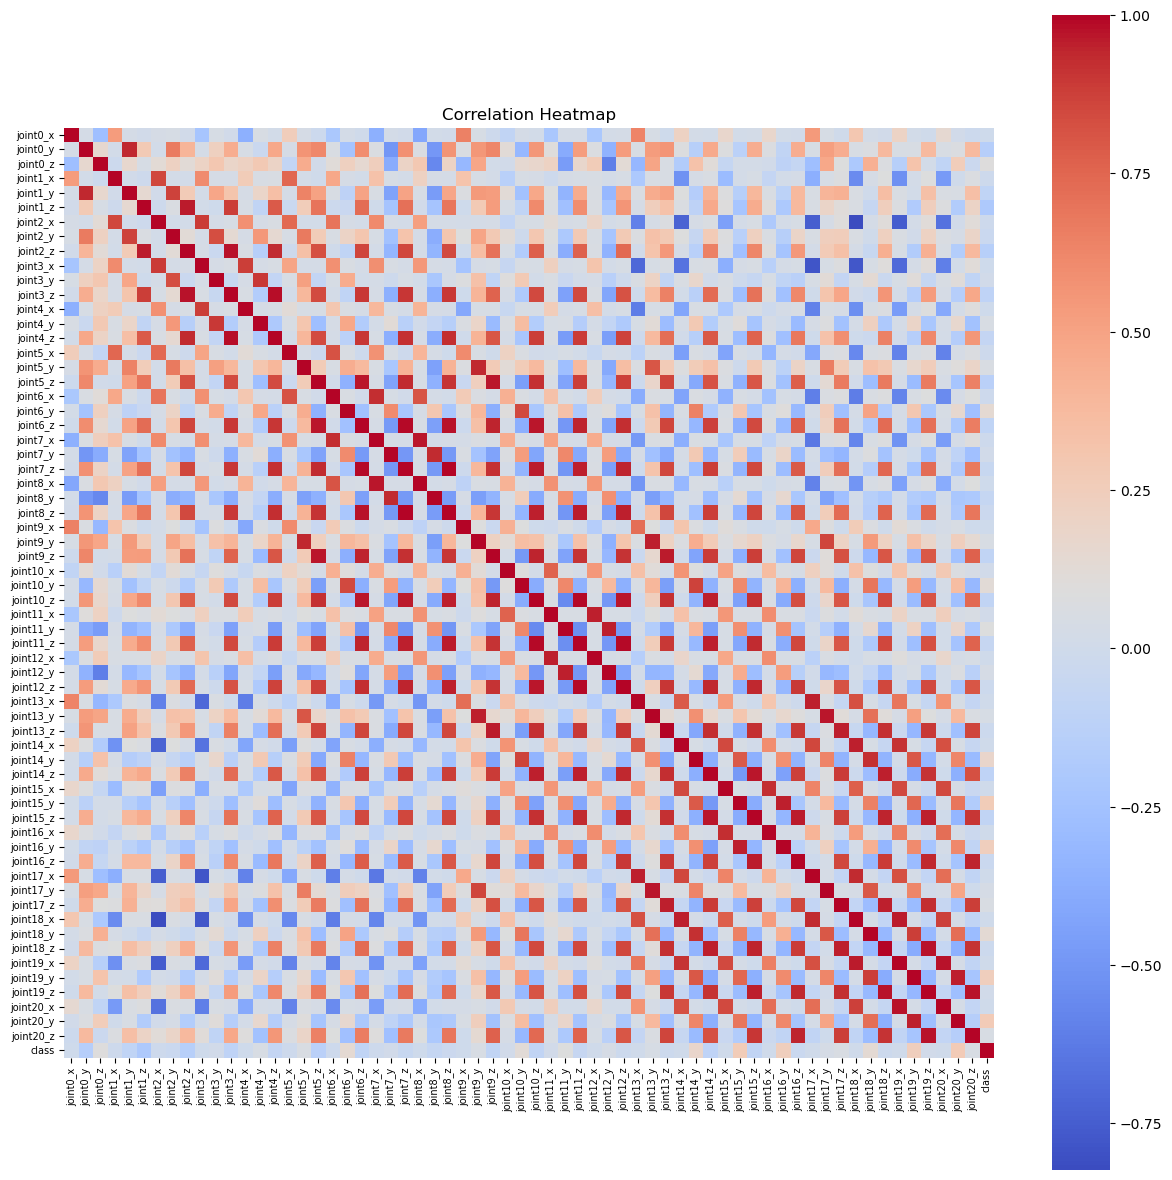

In [9]:
heatmap(data, 15, 7)

In [10]:
data_no_z = data
for i in range(21):
    data_no_z = data_no_z.drop(f'joint{i}_z', axis=1)

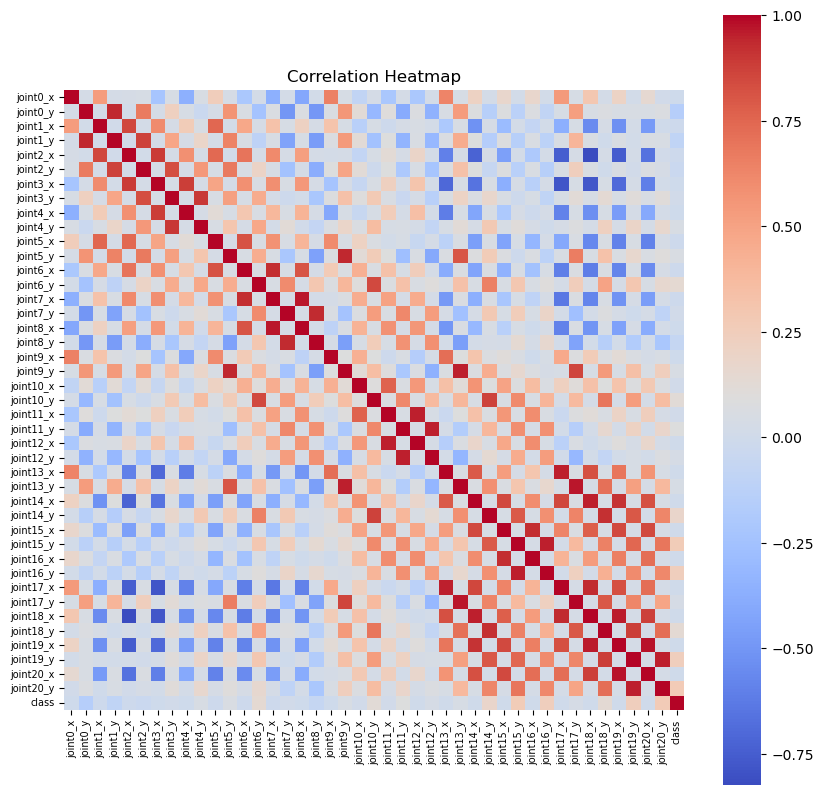

In [11]:
heatmap(data_no_z, 10, 7)

In [12]:
def boxplots(df):
    num_columns = len(df.columns)
    
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(5 * num_columns, 5))
    
    for i, column in enumerate(df.columns):
        sns.boxplot(y=df[column], ax=axes[i])
        axes[i].set_title(f'Boxplot of {column}')
        axes[i].set_ylabel('Values')
    
    plt.tight_layout()
    plt.show()

In [13]:
# groups = data_no_z.groupby('class')
# for name, df in groups:
#     print(list(mapping.keys())[list(mapping.values()).index(name)])
#     boxplots(df)

In [14]:
# len(groups)

In [15]:
def split_dataset(df, target_column, test_size=0.2, random_state=None):

    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = split_dataset(df=data_no_z, target_column='class')

In [17]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
y_pred = clf.predict(X_test)

In [19]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report)
report_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,accuracy,macro avg,weighted avg
precision,0.983105,0.993494,0.951943,0.957408,0.978782,0.990933,0.917170,0.904888,0.954355,0.932440,...,0.966118,0.983120,0.969900,0.974308,0.907574,0.826389,0.834286,0.950143,0.937168,0.950018
recall,0.984454,0.991651,0.956676,0.969711,0.975184,0.991789,0.921212,0.886731,0.950366,0.934444,...,0.965663,0.986722,0.973154,0.973346,0.899491,0.802247,0.794918,0.950143,0.935524,0.950143
f1-score,0.983779,0.992572,0.954304,0.963520,0.976980,0.991361,0.919186,0.895718,0.952356,0.933441,...,0.965890,0.984918,0.971524,0.973827,0.903514,0.814139,0.814126,0.950143,0.936304,0.950057
support,2187.000000,2156.000000,1408.000000,2179.000000,2176.000000,2314.000000,1815.000000,1545.000000,1914.000000,1861.000000,...,2126.000000,2184.000000,2086.000000,2026.000000,1572.000000,445.000000,551.000000,0.950143,49161.000000,49161.000000


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import time

In [18]:
classifiers = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
    ('Bagging with KNN', BaggingClassifier(KNeighborsClassifier(), random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

In [47]:
results = {}
times = {}

def train_and_evaluate(clf, clf_name, X_train, y_train, X_test, y_test):
    s_time = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[clf_name] = accuracy
    total = time.time() - s_time
    times[clf_name] = total
    print(f"{clf_name} accuracy: {accuracy:.4f}, time: {total}")

for clf_name, clf in classifiers:
    train_and_evaluate(clf, clf_name, X_train, y_train, X_test, y_test)

Decision Tree accuracy: 0.9501, time: 10.938741683959961


C:\Users\dfoda\anaconda3\envs\ASLRecognition\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.8775, time: 24.012613773345947
Random Forest accuracy: 0.9828, time: 102.93399834632874
Support Vector Machine accuracy: 0.9831, time: 440.42758679389954
Gaussian Naive Bayes accuracy: 0.8306, time: 0.8913209438323975
K-Nearest Neighbors accuracy: 0.9830, time: 212.24287366867065
Linear Discriminant Analysis accuracy: 0.8806, time: 1.9968791007995605
Bagging with KNN accuracy: 0.9829, time: 2070.3787229061127


C:\Users\dfoda\anaconda3\envs\ASLRecognition\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost accuracy: 0.2537, time: 43.483771562576294
Gradient Boosting accuracy: 0.9629, time: 3422.2793934345245
CatBoost accuracy: 0.9828, time: 1744.4559452533722


In [117]:
print("\nResults summary:")
for clf_name, accuracy in results.items():
    print(f"{clf_name}: {accuracy:.4f}, time: {times[clf_name]:.4f} seconds")

sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

# График точности
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_results.keys(), sorted_results.values(), color='blue')
plt.title('Accuracy of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim([0, 1.1]) 
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    if height < 1.0:
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', clip_on=True)

plt.show()

sorted_times = dict(sorted(times.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_times.keys(), sorted_times.values(), color='green')
plt.title('Training Time of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    if height <= max(sorted_times.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', clip_on=True)

plt.show()


Results summary:


NameError: name 'results' is not defined

In [65]:
knn = KNeighborsClassifier()

In [72]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],    # количество соседей
    'weights': ['uniform', 'distance'], # веса соседей (равномерные или в зависимости от расстояния)
    'p': [1, 2]                         # параметр для метрики расстояния (1 - манхэттенское расстояние, 2 - евклидово расстояние)
}


In [80]:
for n in (param_grid['n_neighbors']):
    for w in (param_grid['weights']):
        for p in (param_grid['p']):
            knn = KNeighborsClassifier(n_neighbors=n, weights=w, p=p)
            s = time.time()
            knn.fit(X_train, y_train)
             
            y_pred = knn.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Params: n_neighbors={n}, weights={w}, p={p} => Accuracy: {accuracy:.4f}, Time: {time.time() - s:.2f}")

Params: n_neighbors=3, weights=uniform, p=1 => Accuracy: 0.9833, Time: 391.76
Params: n_neighbors=3, weights=uniform, p=2 => Accuracy: 0.9842, Time: 163.24
Params: n_neighbors=3, weights=distance, p=1 => Accuracy: 0.9847, Time: 382.10
Params: n_neighbors=3, weights=distance, p=2 => Accuracy: 0.9851, Time: 144.87
Params: n_neighbors=5, weights=uniform, p=1 => Accuracy: 0.9824, Time: 424.06
Params: n_neighbors=5, weights=uniform, p=2 => Accuracy: 0.9830, Time: 210.28
Params: n_neighbors=5, weights=distance, p=1 => Accuracy: 0.9836, Time: 484.21
Params: n_neighbors=5, weights=distance, p=2 => Accuracy: 0.9840, Time: 209.40
Params: n_neighbors=7, weights=uniform, p=1 => Accuracy: 0.9807, Time: 468.93
Params: n_neighbors=7, weights=uniform, p=2 => Accuracy: 0.9815, Time: 190.02
Params: n_neighbors=7, weights=distance, p=1 => Accuracy: 0.9820, Time: 455.39
Params: n_neighbors=7, weights=distance, p=2 => Accuracy: 0.9827, Time: 195.82
Params: n_neighbors=9, weights=uniform, p=1 => Accuracy: 0

In [20]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [23]:
def detect_hand(image, hands, padding=20, target_size=(300, 300), bg_color=(128, 128, 128)):
    rgb_image = image
    rgb_image.flags.writeable = False

    results = hands.process(rgb_image)

    rgb_image.flags.writeable = True

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            h, w, _ = image.shape
            x_min, y_min = w, h
            x_max, y_max = 0, 0

            landmarks = []

            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)
                landmarks.append((x, y, landmark.z))

            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(w, x_max + padding)
            y_max = min(h, y_max + padding)

            hand_image = image[y_min:y_max, x_min:x_max]

            hand_h, hand_w, _ = hand_image.shape
            scale = min(target_size[0] / hand_w, target_size[1] / hand_h)
            new_w = int(hand_w * scale)
            new_h = int(hand_h * scale)
            resized_hand_image = cv2.resize(hand_image, (new_w, new_h))

            result_image = np.full((target_size[1], target_size[0], 3), bg_color, dtype=np.uint8)
            x_offset = (target_size[0] - new_w) // 2
            y_offset = (target_size[1] - new_h) // 2
            result_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_hand_image

            return result_image, results, (x_min, y_min, scale, x_offset, y_offset), landmarks
    return None, None, None, None


In [24]:
def adjust_landmarks(landmarks, x_min, y_min, scale, x_offset, y_offset):
    adjusted_landmarks = []
    for x, y, z in landmarks:
        x_new = int((x - x_min) * scale + x_offset)
        y_new = int((y - y_min) * scale + y_offset)
        adjusted_landmarks.append((x_new, y_new, z))
    return adjusted_landmarks

In [25]:
def get_hand_landmarks(image, hands):
    image_rgb = image.copy()

    image_rgb.flags.writeable = False
    results_new = hands.process(image_rgb)
    image_rgb.flags.writeable = False

    all_hand_landmarks = []

    if results_new.multi_hand_landmarks:
        for hand_landmarks in results_new.multi_hand_landmarks:
            hand_coords = []
            h, w, c = image.shape

            for landmark in hand_landmarks.landmark:
                cx, cy = int(landmark.x * w), int(landmark.y * h)
                hand_coords.append((cx, cy, landmark.z))

            all_hand_landmarks.append(hand_coords)

    return all_hand_landmarks, results_new

In [114]:
def start_camera(model):
    total_images = 0
    total_time = 0
    while True:
        success, image = cap.read()
        image = cv2.flip(image, 1)
        
        hand_pattern, results_pattern, bbox_params, original_landmarks = detect_hand(image, hands1)
        if results_pattern:
            for handLms in results_pattern.multi_hand_landmarks:
                draw.draw_landmarks(image, handLms, mp.solutions.hands.HAND_CONNECTIONS)

                x = int(handLms.landmark[0].x * image.shape[1])
                y = int(handLms.landmark[0].y * image.shape[0])
            
        if hand_pattern is not None:
            imageRGB = cv2.resize(hand_pattern, (150, 150))
        
            if original_landmarks:
                adjusted_landmarks = adjust_landmarks(original_landmarks, *bbox_params)
                lmk = lmk2df(adjusted_landmarks)
                time_s = time.time()
                predicted = model.predict(lmk)[0]
                letter = list(mapping.keys())[list(mapping.values()).index(predicted)]
                total_time += time.time() - time_s
                total_images += 1
                dynamic_console_output(letter)
                cv2.putText(image, letter, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 255, 0), 20, cv2.LINE_AA)
            else:
                dynamic_console_output('None')
        else:
            dynamic_console_output('None')
            imageRGB = cv2.resize(image, (150, 150))
            
        image_out = image
        
        height, width, _ = imageRGB.shape
        height_out, width_out, _ = image_out.shape
    
        x_offset = width_out - width
        y_offset = 0
        
        image_out[y_offset:y_offset+height, x_offset:x_offset+width] = imageRGB

        cv2.imshow('Hand', image_out)
        
        if cv2.waitKey(33) != -1:
            cv2.destroyAllWindows()
            cap.release()
            # break
            return total_time / total_images

In [29]:
def lmk2df(landmarks):
    lmk_dict = {}
    for idx, coords in enumerate(landmarks):
        lmk_dict[f'joint{idx}_x'] = [coords[0]]
        lmk_dict[f'joint{idx}_y'] = [coords[1]]

    return pd.DataFrame(lmk_dict)

In [30]:
def dynamic_console_output(log):
    if isinstance(log, list | tuple | set):
        log_temp = ''
        for i in log:
            log_temp += str(i) + ' '
        log = log_temp
    terminal_width = shutil.get_terminal_size().columns

    log = log.ljust(terminal_width)
    
    sys.stdout.write("\r\033[K" + log)
    sys.stdout.flush()

In [119]:
cap = cv2.VideoCapture(0)

mp_drawing = mp.solutions.drawing_utils
hands1 = mp.solutions.hands.Hands(
        max_num_hands=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)

In [116]:
start_camera(knn)

None                                                                                                                    

0.045502006643415714

In [101]:
cap.release()

In [97]:
def predict_images_in_folder(folder_path, model):
    predictions = []
    true_labels = []
    
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    for subfolder in subfolders:
        class_name = os.path.basename(subfolder)
        print(f'Processing images in class: {class_name}')
     
        files = [f for f in os.listdir(subfolder) if f.endswith('.jpg') or f.endswith('.png')]
        
        for file in files:
            image_path = os.path.join(subfolder, file)
            image = cv2.imread(image_path)

            hand_pattern, results_pattern, bbox_params, original_landmarks = detect_hand(image, hands1)
            if hand_pattern is not None:            
                if original_landmarks:
                    adjusted_landmarks = adjust_landmarks(original_landmarks, *bbox_params)
                    lmk = lmk2df(adjusted_landmarks)
                    predicted = model.predict(lmk)[0]
                    letter = list(mapping.keys())[list(mapping.values()).index(predicted)]
                else:
                    letter = 'nothing'
            else:
                letter = 'nothing'
            predictions.append(letter)
            true_labels.append(class_name)
            
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy}')

In [98]:
path = 'data/test_images'
predict_images_in_folder(path, knn)

Processing images in class: A
Processing images in class: B
Processing images in class: C
Processing images in class: D
Processing images in class: del
Processing images in class: E
Processing images in class: F
Processing images in class: G
Processing images in class: H
Processing images in class: I
Processing images in class: J
Processing images in class: K
Processing images in class: L
Processing images in class: M
Processing images in class: N
Processing images in class: nothing
Processing images in class: O
Processing images in class: P
Processing images in class: Q
Processing images in class: R
Processing images in class: S
Processing images in class: space
Processing images in class: T
Processing images in class: U
Processing images in class: V
Processing images in class: W
Processing images in class: X
Processing images in class: Y
Processing images in class: Z
Accuracy: 0.6720689655172414
